# **ML Course 2024 |  Medical Expenses Prediction Challenge**

This notebook should serve as a starting point to work on the project. Please read the project description first.

In [ ]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

# **Introduction**

## Set team ID
Important: set your Team ID here. You can find it in CMS.

In [60]:
team_id = "18"  # Our team ID

## [Colab only] Connect to your Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# **Imports**

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [ ]:
pip install matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:


pip install pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn import linear_model, preprocessing
from sklearn.model_selection import ShuffleSplit

from models.model import Dataset
from utils import metrics as my_metrics
from utils import scorers, tuning
from utils.config import CUML_INSTALLED
from utils.helpers import parse_cv_results

if CUML_INSTALLED:
    from cuml.linear_model import Lasso, LinearRegression, Ridge
    from cuml.svm import SVR
else:
    from sklearn.linear_model import Lasso, LinearRegression, Ridge
    from sklearn.svm import SVR

# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

# **Data Analysis & Preprocessing**

## Load Data

In a first step, we load the provided training data from the csv file

In [33]:
df_train = Dataset("data/train.csv")
print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 110 columns


In [34]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,TOT_MED_EXP,UTILIZATION
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,0,2,2,2,1,43.82,61.41,3,0,LOW
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,12,2,2,2,0,60.12,54.80,0,240,LOW
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,20,2,2,2,0,60.35,30.08,0,791,LOW
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,20,2,2,2,0,58.32,50.22,0,272,LOW
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,3,2,2,2,0,62.39,56.71,0,1264,LOW


## Data exploration

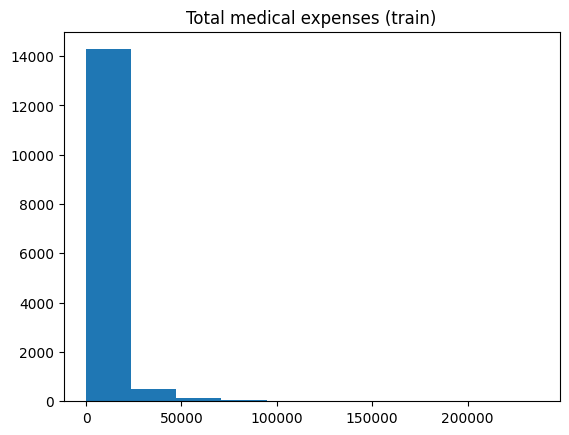

In [35]:
# TODO: explore the data thoroughly, i.e. look for missing values, plot feature histograms, etc

# This is a (rather bad) plot to get you started:
plt.hist(df_train['TOT_MED_EXP'])
plt.title("Total medical expenses (train)")
plt.show()

<Axes: >

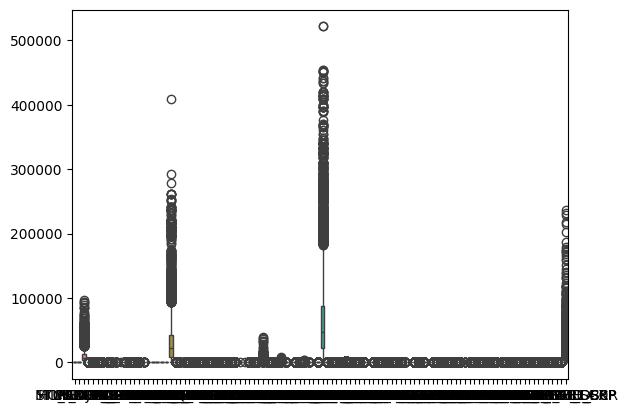

In [36]:
# [ ] TODO: Check Outliers
#df_train.describe()
import seaborn as sns
sns.boxplot(df_train)

In [37]:
# [ ] TODO: Check Normal Distribution

## **Data Preprocessing**

In [38]:
df_train.check_missing_values()

No missing values found in the dataset.


In [39]:
print(df_train)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------------------------------------------------+
| Column Name (Total=110) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                                            Value Counts                                            |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------------------------------------------------+
|        INSUR_COV        | Categorical |           |                    |        |           |           |           |            |                    {1: '8873 (59.15%)', 2: '4017 (26.78%)', 3: '2110 (14.07%)'}                    |
|        POVRTY_CAT       | Categorical |           |           

In [40]:
df_train.fill_missing_values()
df_train.encode_categorical(omit_cols=[CLF_TARGET])
print(df_train)

2024-08-10 01:53:16,794 - root - INFO - Encoding categorical columns ['REGION', 'INSUR_COV', 'POVRTY_CAT', 'SPOUSE_PRSNT', 'SEX', 'RACE'] using one-hot encoding.
2024-08-10 01:53:16,795 - root - INFO - Fitting a new OneHotEncoder for categorical columns: ['REGION', 'INSUR_COV', 'POVRTY_CAT', 'SPOUSE_PRSNT', 'SEX', 'RACE']
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------+
| Column Name (Total=116) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                    Value Counts                    |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------+
|       INSUR_COV_2       | Categorical |           |                    |        |           |           |           

In [41]:
df_train.scale_numerical(method="arcsinh", omit_cols=[REG_TARGET])
print(df_train)

2024-08-10 01:53:17,126 - root - INFO - Fitting a new scaler (FunctionTransformer(func=<function arcsinh_transform at 0x0000025021662D40>)) using the dataset. Omitting ['TOT_MED_EXP'].
+-------------------------+-------------+----------+--------------------+--------+---------+---------+----------+------------+----------------------------------------------------+
| Column Name (Total=116) |     Type    |   Mean   | Standard Deviation |  Min   |   25%   |   50%   |   75%    |    Max     |                    Value Counts                    |
+-------------------------+-------------+----------+--------------------+--------+---------+---------+----------+------------+----------------------------------------------------+
|       INSUR_COV_2       | Categorical |          |                    |        |         |         |          |            |   {0.0: '10983 (73.22%)', 1.0: '4017 (26.78%)'}    |
|       INSUR_COV_3       | Categorical |          |                    |        |         |   

In [44]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 2.3 MB/s eta 0:00:54
   ---------------------------------------- 0.5/124.9 MB 5.1 MB/s eta 0:00:25
   ---------------------------------------- 0.8/124.9 MB 6.7 MB/s eta 0:00:19
   ---------------------------------------- 1.1/124.9 MB 6.8 MB/s eta 0:00:19
    --------------------------------------- 1.6/124.9 MB 7.9 MB/s eta 0:00:16
    --------------------------------------- 2.6/124.9 MB 10.3 MB/s eta 0:00:12
   - -------------------------------------- 3.5/124.9 MB 11.0 MB/s eta 0:00:12
   - -------------------------------------- 4.4/124.9 MB 12.2 MB/s eta 0:00:10
   - -------------------------------------- 5.5/124.9 MB 13.4 MB/s eta 0:00:09
   -- ------------------------------------- 6.3/124.9 MB 14.3 MB/s eta 0:00:09
   -- ------------------------------------- 6.7/124.9 MB 14.2 MB/s eta 0:00:09
   -- ------------------------------------- 8.1/124.9 MB 15.6 MB/


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV




# Linear regression

In [46]:
# Assuming 'df_train' is your DataFrame and 'UTILIZATION' is your target variable
X = df_train.drop(columns=['UTILIZATION', 'TOT_MED_EXP'])  # Drop target and any non-feature columns
y = df_train['UTILIZATION'].apply(lambda x: 1 if x == 'HIGH' else 0)  # Convert to binary

# Step 1: Feature Selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_kbest = selector.fit_transform(X, y)
selected_features_kbest = X.columns[selector.get_support()]

# Step 2: Further refine using Recursive Feature Elimination (RFE)
model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(model, n_features_to_select=10)  # Select top 10 features
X_rfe = rfe.fit_transform(X_kbest, y)

# Match the reduced feature set to the selected feature names
selected_features_rfe = selected_features_kbest[rfe.get_support()]

print(f"Selected features after RFE: {selected_features_rfe}")

Selected features after RFE: Index(['HEALTH_STAT', 'WALK_LIM', 'AGE', 'MULT_HIGHBP', 'HOUSEWRK_LIM',
       'SCHOOL_LIM', 'OCCUP', 'NO_WORK_WHY', 'ARTHR_TYPE', 'NUM_PRESCR_MEDS'],
      dtype='object')


# **Linear classification**

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Process the data

In [53]:
# Step 3: Use the selected features for the final dataset
X_final = df_train[selected_features_rfe]

# Step 4: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Step 5: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [54]:
# Step 6: Train an XGBoost model with initial hyperparameters
clf = xgb.XGBClassifier(
    objective='binary:logistic',  # Use 'multi:softmax' for multiclass classification
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

clf.fit(X_train_scaled, y_train)


c:\Users\Tulasi Nayak\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [56]:
# Step 7: Evaluate the model
y_train_pred= clf.predict(X_train_scaled)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9435
           1       0.89      0.65      0.75      2565

    accuracy                           0.91     12000
   macro avg       0.90      0.81      0.85     12000
weighted avg       0.91      0.91      0.90     12000



In [57]:
# Step 7: Evaluate the model
y_val_pred = clf.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2353
           1       0.67      0.47      0.55       647

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.73      3000
weighted avg       0.82      0.84      0.82      3000



In [58]:
# Step 8: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}
grid_search = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_clf = grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Tulasi Nayak\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [59]:
# Step 9: Final Evaluation
y_val_pred_best = best_clf.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred_best))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2353
           1       0.73      0.49      0.59       647

    accuracy                           0.85      3000
   macro avg       0.80      0.72      0.75      3000
weighted avg       0.84      0.85      0.84      3000



### Fit the model by using training data

Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [70]:
# Run this to save a file with your predictions on the test set to be submitted
split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = Dataset(
    f"data/{split}.csv", scaler=df_train.scaler, categorical_encoder=df_train.categorical_encoder
)

df_test.fill_missing_values()
df_test.encode_categorical() 
df_test.scale_numerical()

print(df_test)

# No target because this is the test set
X_test, _ = df_test.get_X_y(target=None)

# Ensure the test data has the same features as selected during training
X_test_kbest = selector.transform(X_test)  # Apply the SelectKBest transformation
X_test_rfe = rfe.transform(X_test_kbest)   # Apply the RFE transformation


y_hat = clf.predict(X_test_rfe)
# Step 6: Display the predictions (optional)
print("Predictions on the test set:", y_hat)
# Save the results with the format <TEAM_ID>__<SPLIT>__clf_pred.npy

folder = "./results"
np.save(os.path.join(folder, f"{team_id}__{split}__clf_pred.npy"), y_hat)
print(f"Predictions saved to {folder}/{team_id}__{split}__clf_pred.npy")

2024-08-10 02:34:10,196 - root - INFO - Encoding categorical columns ['REGION', 'INSUR_COV', 'POVRTY_CAT', 'SPOUSE_PRSNT', 'SEX', 'RACE'] using one-hot encoding.
2024-08-10 02:34:10,196 - root - INFO - Using existing OneHotEncoder. Encoding categorical columns: ['REGION', 'INSUR_COV', 'POVRTY_CAT', 'SPOUSE_PRSNT', 'SEX', 'RACE']
2024-08-10 02:34:10,223 - root - INFO - Using existing scaler (FunctionTransformer(func=<function arcsinh_transform at 0x0000025021662D40>)). Omitting [].
+-------------------------+-------------+--------+--------------------+--------+--------+--------+--------+--------+----------------------------------------------+
| Column Name (Total=114) |     Type    |  Mean  | Standard Deviation |  Min   |  25%   |  50%   |  75%   |  Max   |                 Value Counts                 |
+-------------------------+-------------+--------+--------------------+--------+--------+--------+--------+--------+----------------------------------------------+
|       INSUR_COV_2   

c:\Users\Tulasi Nayak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


# **Submission to CMS**

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.